In [61]:
import numpy as np
from array import array
from os import stat
import matplotlib.pyplot as plt
import socket
import scipy.signal as signal

DEBUG_INFOS = True

# Offline berechnung

# Dastellung im Frequenzbereich
Um die Signale im Frequenzberich abbilden zu können, wird ein Spectrogramm benötigt, welche falblich die Signalsstärke anzeigt, sowie auf de nAchsen das Freqeunsspektrum und die Anzahl der Abtastungen

In [62]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def analysis_DFTFB(x,w,fftlen,ts):
    # analysis FB
    # x      : input signal
    # w      : window
    # fftlen : FFT size, not exceeding the window length
    # ts     : downsampling factor, not exceeding the window length

    x_shape = x.shape
    y = np.reshape(x,(int(np.prod(x_shape[0:-1])),x_shape[-1]))
    n_symbols = int(np.ceil(x_shape[-1]/ts))
    z = np.zeros((int(np.prod(x_shape[0:-1])),n_symbols,fftlen),dtype=np.complex64)
    for i in range(y.shape[0]):
        yi = np.concatenate((y[i,:],np.zeros((ts-(x_shape[-1]%ts))%ts)))
        yi = yi.reshape((n_symbols,ts))
        wi = np.zeros((n_symbols,len(w)),dtype=np.complex64)
        for j in range(0,int(np.ceil(len(w)/ts))):
            i1 = np.minimum((j+1)*ts,len(w))
            wi[0:n_symbols-j,j*ts:i1] = np.tile(w[j*ts:i1],(n_symbols-j,1))*yi[j:,0:i1-j*ts]
        for j in range(1,int(np.ceil(len(w)/fftlen))):
            i1 = np.minimum((j+1)*fftlen,len(w))
            wi[:,0:i1-j*fftlen] = wi[:,0:i1-j*fftlen]+wi[:,j*fftlen:i1]
        z[i,:,:] = np.fft.fft(wi[:,0:fftlen])
    return z.reshape((x_shape[0:-1]+(n_symbols,fftlen)))

def display_spectrogram(x):
    fftlen = 64
    ts = 2
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    # display spectrum
    levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
    yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
    fig = plt.figure()
    im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
    fig.colorbar(im,ax=fig.gca())
    fig.gca().set_title('spectrogram')
    plt.show()

def display_spectrogram_if_signal(x,signal_strength):
    fftlen = 1024
    ts = 8
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    if(z.max() >= signal_strength):
        # display spectrum
        levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
        cmap = plt.get_cmap('PiYG')
        norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
        xp,yp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]               # yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
        fig = plt.figure()
        im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
        fig.colorbar(im,ax=fig.gca())
        fig.gca().set_title('spectrogram')
        plt.show()

In [63]:
# # loading Preambel
# filename = r"C:\Users\yanni\OneDrive\Documents\Hochschule\5.Semester\PAIND\preamble.sig"
# n_float32 = int(stat(filename).st_size/4)
# with open(filename,"rb") as binary_file:
#     pre = array('f')
#     pre.fromfile(binary_file,n_float32)
# pre = np.array(pre.tolist()[::2])+1j*np.array(pre.tolist()[1::2])
# pre /= np.amax(np.abs(pre))      # normalize to 1
# pre -= np.mean(pre)              # remove DC
# print("signal size:",pre.shape[0])


# Referenzsignal
In einem externen Dokument können alle möglichen Symbole generiert werden. Diese werden dann benutzt, um diese mit dem aufgenommenen Signal zu vergleichen und übereinstimmungen zu erkennen.

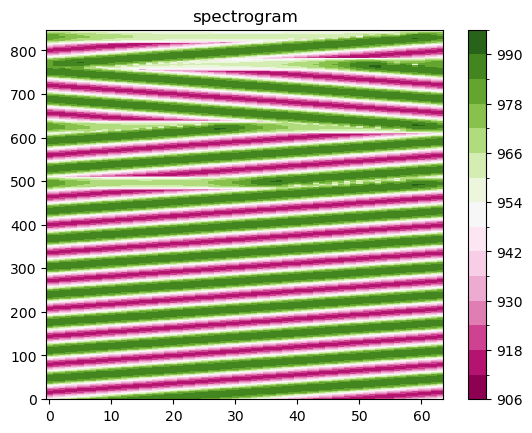

Size of a Zero Symbol: 128
Size of a Preamle Symbol: 1696


In [64]:
# Starterkennung
import Preambel as pre
SF = 7 # SpreadingFactor

signal_zero = pre.GetUpchirp(SF)
preamble = pre.GetPreamble(SF)
display_spectrogram(preamble)
print(f"Size of a Zero Symbol: {len(signal_zero)}")
print(f"Size of a Preamle Symbol: {len(preamble)}")

In [65]:
# Alternive für offline Signale (NOT recommended)
def get_startpoint(signal_t,start_symbol,threshold):
    result = np.correlate(signal_t,start_symbol)
    Start_Position = np.argmax(np.array(result)>threshold)
    print(f"Startpunkt: {Start_Position}")
    return Start_Position

import Preambel as pre
import math

def demod_symbols(signal_t:complex) -> (complex,complex):
    """ 
    Addes an selected "Sample Time Offset" (STO) and "Carrier Frequency Offset" (CFO) to the Signal 
    This fixed offset error is a sign of a detectet preamble and its CFO & STO

    Parameters: 
        signal_t    (complex array) : input signal in timeform 

    Returns:
        index       (complex array) : Position of each frequency-jump along all samples 
        symbols     (complex array) : Maximum value of each frequency-jump
    """
    
    signal_zero = pre.GetUpchirp(SF=7)                         # referencesignal
    STEP = len(signal_zero)                                    # size of referencesignal

    if DEBUG_INFOS:
        print(f"demodulate symbols:")
        print(f"    size of signal_t    : {len(signal_t)}")
        print(f"    size of symbol zero : {STEP} \n")


    if len(signal_t) < STEP:
        raise IndexError("the input signal is shorter than a step") # Error: signal is to short

    position = 0
    symbols = []
    index = []
    
    while len(signal_t) >= STEP:
        signal_td = np.multiply(signal_t[0:STEP],np.conj(signal_zero))
        signal_f = abs(np.fft.fft(signal_td))
        symbols.append(round(max(signal_f)))            #findes always the highest value
        index.append(position*STEP + np.array(signal_f).argmax())
        signal_t = signal_t[STEP::]                     # shorten the array by a step
        position += 1
                                   
    return (index,symbols)

def visualize_symbols(signal_t:complex, title = "Demoduliertes Signal") -> None:
    """ 
    Addes an selected "Sample Time Offset" (STO) and "Carrier Frequency Offset" (CFO) to the Signal 
    This fixed offset error is a sign of a detectet preamble and its CFO & STO

    Parameters: 
        signal_t    (complex array) : input signal in timeform 

    Returns:
        -
    """

    index,symbols = demod_symbols(signal_t)
    plt.plot(index,symbols,'x',)
    plt.ylim([1, 2**SF*1.25])

    plt.xlabel("Samples")
    plt.ylabel("Max Symbol")
    plt.title(title)
    # X => Offset vom Symbol => Symbolwert => ACHTUNG: Beinhaltet CFO & STO")
   
    steps_x = np.arange(0,len(signal_t),128)
    steps_y = np.arange(0,144,16)

    plt.yticks(steps_y)
    plt.xticks(steps_x)
    plt.grid()

    for i in range(len(index)):
        plt.annotate(f"Y{symbols[i]}", (index[i], symbols[i]), xytext=(index[i], symbols[i] + 5))           # shows the value of the Y value
        plt.annotate(f"X{index[i]-(i*128)}", (index[i], symbols[i]), xytext=(index[i], symbols[i] + 10))    # shows the Value of the X value

    plt.show()


In [66]:
def real_preamble(preamble:complex,sample_time_shift:int = 0 ,center_frequency_shift:int = 0) -> complex:
    """ 
    Addes an selected "Sample Time Offset" (STO) and "Carrier Frequency Offset" (CFO) to the Signal 
    This fixed offset error is a sign of a detectet preamble and its CFO & STO

    Parameters: 
        preamble                (complex array) : input signal
        sample_time_shift       (int)           : timeshift in number of samples (positive forward & negative backward)
        center_frequency_shift  (int)           : frequencyshift  of the signal in degrees steps of the size 360/128    {0,..,128}

    Returns:
        position            (int) : gives the startpoint of the preample in the index array back. If none -1 will be returned
    """
    # Timeshift
    if (sample_time_shift != 0):
        preamble = np.roll(preamble,-sample_time_shift)

    # Frequencyshift
    if(center_frequency_shift != 0):
        center_frequency_shift = np.exp(2j*np.pi*np.arange(len(preamble))*center_frequency_shift/128)
        preamble = np.multiply(preamble,center_frequency_shift)

    return preamble

In [67]:
# print("Perfect Preamble")
# display_spectrogram(preamble)
# preamble_t = real_preamble(preamble,200,0) # Timeoffset
# print("Preamble with Timeoffset")
# display_spectrogram(preamble_t)
# preamble_f = real_preamble(preamble,0,30) # Frequencyoffset
# print("Preamble with Frequencyoffset")
# display_spectrogram(preamble_f)

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



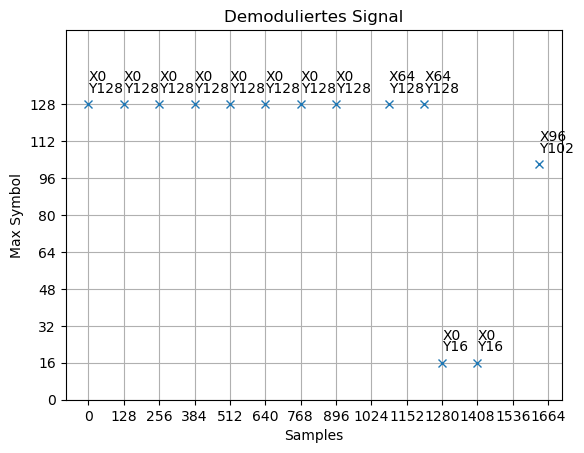

In [68]:
preamble_t = real_preamble(preamble,10,0)   # Timeoffset (STO) by 10 Samples
preamble_f = real_preamble(preamble,0,10)   # Frequencyoffset (CFO) by 10*360/128
preamble_tf= real_preamble(preamble,0,0)    # CFO & STO
visualize_symbols(preamble_tf)

In [69]:
def preamble_to_delta(index:complex,symbols:complex) -> (complex,complex):
    """ 
    subtracts the index to the offset 

    Parameters: 
        index   (complex array) : Position of each frequency-jump along all samples 
        symbols (complex array) : Maximum Value of each frequency-jump

    Returns:
        index   (complex array) : Offset of each frequency-jump to a fixed symbollenght of 128 Samples 
        symbols (complex array) : Maximum Value of each frequency-jump (unchanged)
    """

    index_delta = index.copy()                     # no .copy is needed
    symbols_delta = symbols
    for x in range(len(index)):
        index_delta[x] =index[x] - 128*x
    return(index_delta,symbols_delta)

def preamble_detection_with_delta(index_delta:complex, symbols_delta:complex, position:int = 0, number_of_detected:int = 0) -> int:
    """ 
    Finds with recusion if there are a preset number of the same (+-1) index-offsets.
    This fixed offset-error is a sign of a detected preamble and its CFO & STO

    Parameters: 
        index_delta         (complex array) : Position of each frequency-jump along all samples 
        symbols_delta       (complex array) : Maximum Value of each frequency-jump (unused)
        position            (int)           : Recusion input parameter that tracks the position in the array (start => 0)
        number_of_detected  (int)           : Recusion inpit parameter that tracks the number of th same value in ar row (start => 0)

    Returns:
        position            (int)           : gives the startpoint of the preample in the index array back. If none -1 will be returned
    """

    if number_of_detected >= 7: # number of preambles -1
        preamble_start = position-7
        return preamble_start       # start position of the preamble
    
    if (position+1) >= len(index_delta):
        return -1               # not detectet a preamble
    
    if(index_delta[position+1] in range(index_delta[position-number_of_detected]-1,index_delta[position-number_of_detected]+1)):        # Decection of repetition with +-1 error posiiblitity (STO < 1 Sample)
        return preamble_detection_with_delta(index_delta,symbols_delta,position+1,number_of_detected+1)    # recursion when a preamble is there
    else:
        return preamble_detection_with_delta(index_delta,symbols_delta,position+1,0)                       # recusion if a preamble isn't there

def preamble_detection(index:complex,symbols:complex) -> int:
    """ 
    detects a preamble in the date if ther is one and returns the position
    Parameters: 
        index       (complex array) : Position of each frequency-jump along all samples 
        symbols     (complex array) : Maximum Value of each frequency-jump

    Returns:
        position    (int)           : Gives the startpoint of the preample in the index array back. If none -1 will be returned
    """
        
    delta_index,delta_symbols = preamble_to_delta(index,symbols)
    start_position_of_preamble = -2

    start_position_of_preamble = preamble_detection_with_delta(delta_index,delta_symbols,position=0,number_of_detected = 0)
    return start_position_of_preamble


In [70]:
def demodulate_detected(signal_t:complex)-> (complex,complex):
    (index,symbols) = demod_symbols(signal_t)
    (index_delta,symbols_delta) = preamble_to_delta(index,symbols)
    start_position_of_preamble = preamble_detection(index_delta,symbols_delta)
    return (index_delta,symbols_delta,start_position_of_preamble)


In [71]:
preamble_ex = real_preamble(preamble,-130,0)  # timeshift more than an hole symbol (new startposition at position 1)
(index,symbols) = demod_symbols(preamble_ex)

start_position_of_preamble = preamble_detection(index,symbols)
if start_position_of_preamble == -1:
    print("Keine Preamble erkannt")
else:
    print(f"Der Start einer Preamble erkannt an der Position: {start_position_of_preamble}")

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 

Der Start einer Preamble erkannt an der Position: 0


In [72]:
PREAMBLE_LENGHT = 8
NETWORK_IDENTIFIER_LENGHT = 2
STEP_SIZE = 128
BANDWIDTH = 125_000

def correction_cfo_int(signal_t:complex, index_delta:complex, symbols_delta:complex, start_position_of_preamble:int) -> complex:
    # Korrigiret den Carrier Frequency Offset
    # letztes Nullsymbol in Y Achse zeigt den Offset

    frequency_upchirp_normalised = index_delta[start_position_of_preamble + PREAMBLE_LENGHT -1] / STEP_SIZE    # Last frequency of the upchirp normalised
    frequency_downchirp_normalised = index_delta[start_position_of_preamble + PREAMBLE_LENGHT + NETWORK_IDENTIFIER_LENGHT] / STEP_SIZE # first frequency of the downchirp normalised
    center_frequency_offset_int = round((frequency_upchirp_normalised + frequency_downchirp_normalised ) / 2 * BANDWIDTH)

    if DEBUG_INFOS:
        print(f"correction of the Carrrier Frequency Offset:")
        print(f"    CFO: {center_frequency_offset_int % STEP_SIZE} \n")

    center_frequency_shift_int = np. exp(2j*np.pi*np.arange(len(signal_t))*-center_frequency_offset_int/STEP_SIZE)
    signal_cfo_int_corrected = np.multiply(signal_t,center_frequency_shift_int)
    return signal_cfo_int_corrected

def correction_sto_int(signal_cfo_corrected:complex, index_delta:complex,symbols_delta:complex, start_position_of_preamble:int) -> complex:
    # Korrigiert den Sample Time Offset
    
    frequency_upchirp_normalised = index_delta[start_position_of_preamble + PREAMBLE_LENGHT -1] / STEP_SIZE    # Last frequency of the upchirp normalised
    frequency_downchirp_normalised = index_delta[start_position_of_preamble + PREAMBLE_LENGHT + NETWORK_IDENTIFIER_LENGHT] / STEP_SIZE # first frequency of the downchirp normalised
    sample_time_offset_int = round((frequency_upchirp_normalised - frequency_downchirp_normalised) / 2 * STEP_SIZE - STEP_SIZE)
    # sample_time_offset_int = index_delta[start_position_of_preamble]

    if DEBUG_INFOS:
        print(f"correction of the Sample Time Offset:")
        print(f"    STO: {-sample_time_offset_int} \n")
        
    signal_sto_int_corrected = np.concatenate((np.zeros(-sample_time_offset_int,dtype=complex),signal_cfo_corrected),dtype=complex) # cut off to the start of the preamble
    
    return signal_sto_int_corrected

def offset_correction(signal_t:complex) -> complex:
    # demodulation
    (index_delta, symbols_delta, start_position_of_preamble) = demodulate_detected(signal_t)
    start_position_of_preamble = 0 # TODO: REMOVE LATER

    signal_cfo_corrected = correction_cfo_int(signal_t,index_delta,symbols_delta,start_position_of_preamble)                # CFO correction

    if DEBUG_INFOS:
        visualize_symbols(signal_cfo_corrected,"signal_cfo_corrected") # visualise

    # demodualation
    (index_delta, symbols_delta, start_position_of_preamble) = demodulate_detected(signal_cfo_corrected)
    start_position_of_preamble = 0 # TODO: REMOVE LATER
    
    signal_int_corrected = correction_sto_int(signal_cfo_corrected,index_delta,symbols_delta,start_position_of_preamble)    # STO correction

    if DEBUG_INFOS:
        visualize_symbols(signal_int_corrected,"signal_int_corrected")

    return signal_int_corrected


In [73]:
def demodulate_detected_corrected(signal_t:complex):
    (index_delta, symbols_delta, start_position_of_preamble) = demodulate_detected(signal_t)
    start_position_of_preamble = 0 # TODO: REMOVE LATER
    if start_position_of_preamble < 0:
        raise IndexError("Index has to be positiv => demodualation failed")
    signal_corrected = offset_correction(signal_t)
    visualize_symbols(signal_corrected,"signal_corrected") # visualise
    return signal_corrected



demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



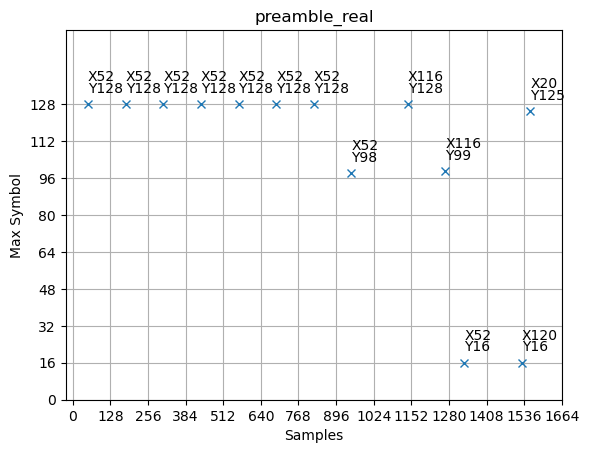

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 

correction of the Carrrier Frequency Offset:
    CFO: 93 

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



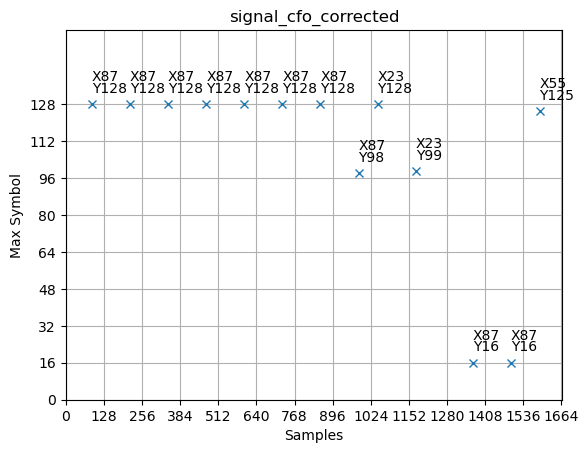

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 

correction of the Sample Time Offset:
    STO: 128 

demodulate symbols:
    size of signal_t    : 1824
    size of symbol zero : 128 



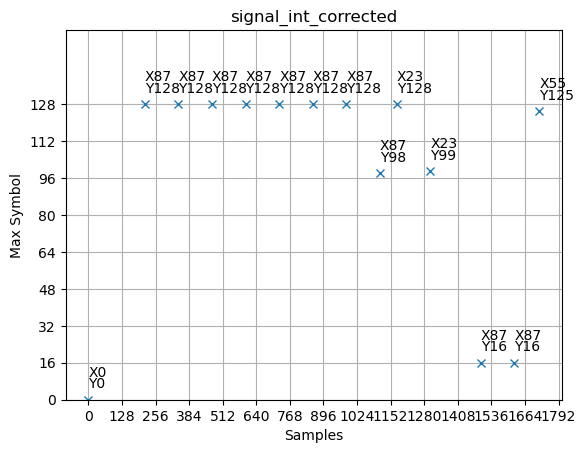

demodulate symbols:
    size of signal_t    : 1824
    size of symbol zero : 128 



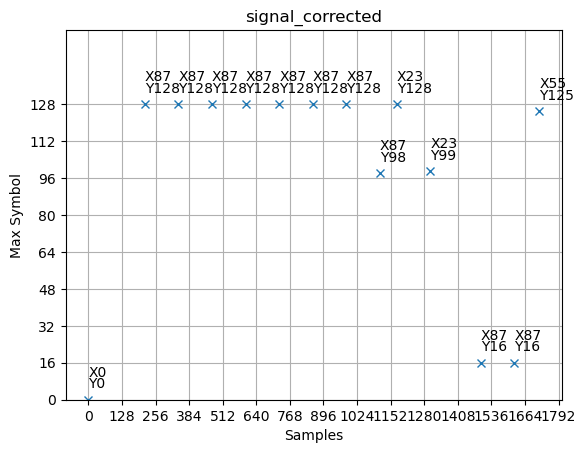

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



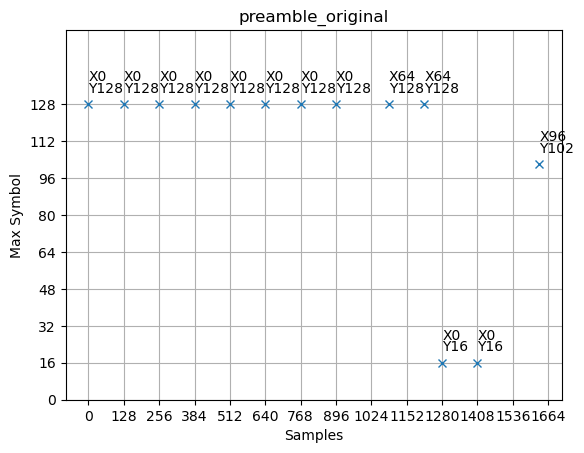

In [74]:
preamble_real= real_preamble(preamble,30,22)  # STO, CFO
visualize_symbols(preamble_real,"preamble_real")

demodulate_detected_corrected(preamble_real)
visualize_symbols(preamble,"preamble_original")



demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



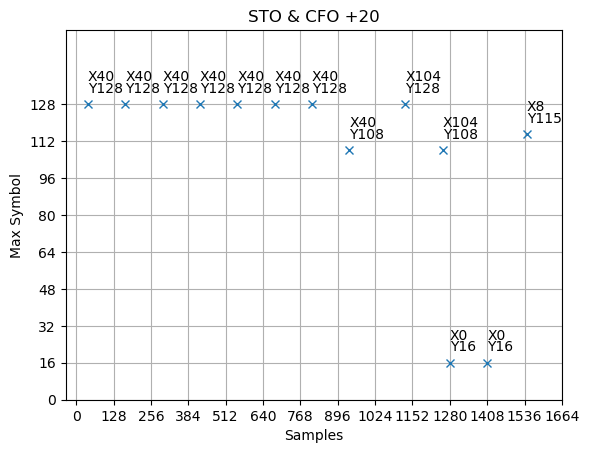

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



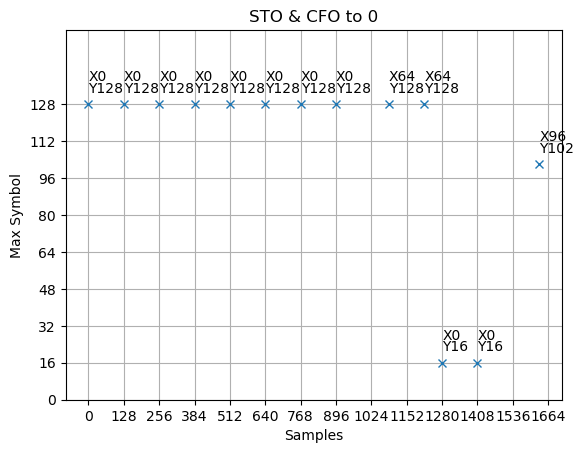

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



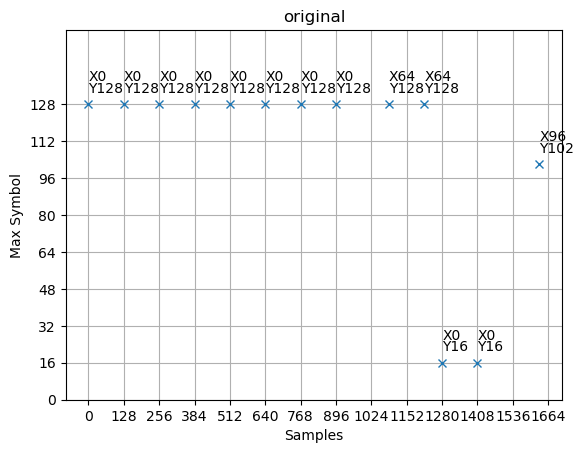

new Exeriment! 

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



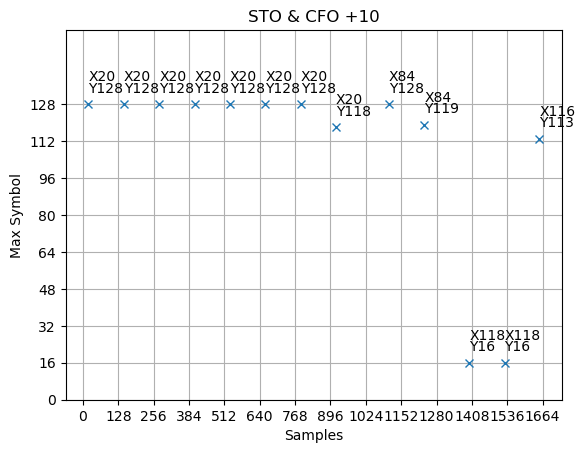

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



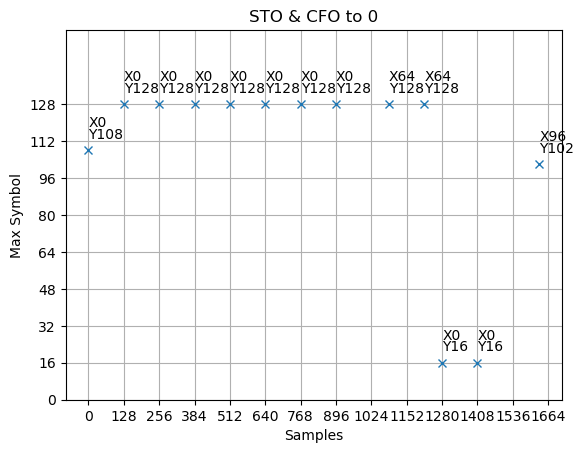

demodulate symbols:
    size of signal_t    : 1696
    size of symbol zero : 128 



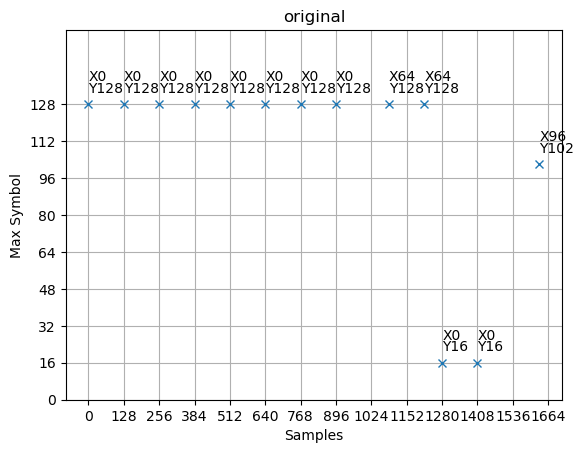

In [75]:
preamble_test = real_preamble(preamble,20,20)
visualize_symbols(preamble_test,"STO & CFO +20")
preamble_test_end = real_preamble(preamble_test,-20,-20)
visualize_symbols(preamble_test_end,"STO & CFO to 0")
visualize_symbols(preamble,"original")

print("new Exeriment! \n")

preamble_test =real_preamble(preamble,10,10)
visualize_symbols(preamble_test,"STO & CFO +10")
preamble_test_end = real_preamble(preamble_test,-10,-10)
visualize_symbols(preamble_test_end,"STO & CFO to 0")
visualize_symbols(preamble,"original")
